In [1]:
%cd ..

D:\SoftUni\Machine Learning\mushrooms project


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from src import functions

In [3]:
mushroom_data = pd.read_csv('data/cleaned_dataset.csv')

In [4]:
mushroom_data

,label,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,w,o,e,w,v,l


### Spliting the dataset
Sklearn "train_test_split" method is used to split the data to train and test subsets. It is shuffled before the split and is stratified by the target variable to preserve it's classes proportion. Accordingly to the size of the dataset and the presence of some rare categories, a 75 / 25 split us used to ensure a decent size and quality of the testing set.

In [5]:
RANDOM_SEED = 11

In [6]:
mushroom_attributes = mushroom_data.drop(columns = ['label'])

In [7]:
mushroom_target = mushroom_data['label']

In [8]:
mushroom_attr_train, mushroom_attr_test, mushroom_target_train, mushroom_target_test = train_test_split(
    mushroom_attributes, mushroom_target, test_size = 0.25, random_state = RANDOM_SEED, stratify = mushroom_target
)

In [9]:
mushroom_attr_train.shape, mushroom_attr_test.shape, mushroom_target_train.shape, mushroom_target_test.shape

((6093, 21), (2031, 21), (6093,), (2031,))

The proportions of target variable have remained the same after the split:

In [10]:
mushroom_data['label'].value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

In [11]:
mushroom_target_train.value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

In [12]:
mushroom_target_test.value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

### Encoding
All feature's values have to be encoded from "str" to numerical data type as needed for proper work with ML algorithms. I will use one - hot encoding since the categories within the features are not ranked or hierarchical, thus label encoding would not be appropriate. Because the presence of some rare categhories, handle_unknown = "ignore" and a list which contains all possible categories are provided as arguments to the encoder.

In [13]:
mushroom_columns = mushroom_attr_train.columns.values

In [14]:
mushroom_categories = [mushroom_attr_train[col].unique() for col in mushroom_columns]

In [15]:
attr_encoder = ColumnTransformer(
    transformers = [
        ('one-hot', OneHotEncoder(handle_unknown = 'ignore', categories = mushroom_categories), mushroom_columns)
    ]
)

### Algorithms

Algorithm selection is based on the applied EDA, characteristics of the dataset and results of previous research. Even with simple algorithms, high values of evaluation metrics have been achieved previously. Indeed, the results of the data analysis showed that some of the features can be of great importance in determining the class of the target variable. At the other hand, the size of the dataset may be not big enough to complex algorithms like XGBoost which are prone to overfitting. Simple classification algorithm like Logistic Regression which can be used initially as a baseline. Applying Random Forest and SVC could rise the performance(w.r.t the evaluation metric) afterwards if needed. Coefficients of Logistic Regression and RF feature importances are usable  

### Evaluation and hyperparameter tuning
To assess the performance of the models is used stratified k - fold cross - validation technique. This approach is suitable because the dataset is relatively small and do not have enough obervations for separate validation set. For this reasos the training set is randomly divided into 5 folds, ensuring that every data point, including those with rare categories, is used in both training and validation.

To distinguish the toxic mushrooms is of great importance. Labeling a poisonous mushroom as edible can be fatal in the real world. For this reasont I want to ensure that when the model predicts "edible" it is actually edible. The appropriate evaluation metric in this case is **recall**:

$$ Recall = \frac{TP}{TP + FN} $$

It shows what part of all "poisonous" labeled mushrooms was retrieved by the model. I will use it as main evaluation metric to asses the performance of the classification models in the project.

Hyperopt library is used for hyperparameter tuning. Negative recall is set as loss metric for optimization since the algorithm tries to minimize it. In addition, accuracy and area under the ROC metrics are observed. Appropriate search space and objective function is defined for each of the used algorithms.

In [16]:
eval_metrics = {
        'recall': make_scorer(recall_score, pos_label = 'p'),
        'accuracy': make_scorer(accuracy_score),
        'roc_auc': 'roc_auc'
    }

### Logistic Regression

#### Training

In [17]:
# def logr_objective(params):
#     pipeline = Pipeline(steps = [
#         ('encode', attr_encoder),
#         ('classifier', LogisticRegression(solver = 'liblinear', random_state = RANDOM_SEED))
#     ])

#     pipeline.set_params(
#         classifier__C = params['C'],
#         classifier__penalty = params['penalty']
#     )

#     skf = StratifiedKFold(n_splits = 5)
    
#     scores = cross_validate(pipeline, mushroom_attr_train, mushroom_target_train, cv = skf, scoring = eval_metrics)

#     return {
#         'loss': -np.mean(scores['test_recall']),
#         'status': STATUS_OK,
#         'other_metrics': {
#             'mean_recall': np.mean(scores['test_recall']),
#             'mean_accuracy': np.mean(scores['test_accuracy']),
#             'mean_roc_auc': np.mean(scores['test_roc_auc'])
#         }
#     }

Logistic Regression algorithm are initialized with "liblinear" solver, taking into consideration the relatively small size of the dataset, and because of the support of both Lasso and Ridge regularization techniques.

Two hyperparameters are included in the optimization search space. "penalty" with two possible values: l1 and l2, and regularization strength "C" which will be tuned between 0.001 and 100. 

In [18]:
logr_search_space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', np.log(1e-3), np.log(1e2))
}

In [19]:
logr_trials = Trials()

logr_fmin = fmin(
    fn = lambda params: functions.hyperopt_objective(
        params = params,
        classifier = 'LogisticRegression', 
        attr_train = mushroom_attr_train,
        target_train = mushroom_target_train,
        eval_metrics = eval_metrics,
        encoder = attr_encoder,
        random_seed = RANDOM_SEED
    ),
    space = logr_search_space,
    algo = tpe.suggest,
    max_evals = 80,
    trials = logr_trials,
    rstate = np.random.default_rng(RANDOM_SEED)
)

100%|██████████████████████████████████████████████████████████████| 80/80 [00:53<00:00,  1.50trial/s, best loss: -1.0]


In [20]:
logr_fmin

{'C': 68.29736138744246, 'penalty': 1}

Minimization function returns "C" = 68.29736138744246 and 'penalty' = 1(L2) as the best values of hyperparameters.

The relevant information from each trial is extracted and visualized as pandas dataframe.

In [21]:
logr_metrics = []
for trial in logr_trials.trials:
    result = trial['result']
    logr_metrics.append({
        'loss': result['loss'],
        'mean_recall': result['other_metrics']['mean_recall'],
        'std_recall': result['other_metrics']['std_recall'],
        'mean_accuracy': result['other_metrics']['mean_accuracy'],
        'std_accuracy': result['other_metrics']['std_accuracy'],
        'mean_roc_auc': result['other_metrics']['mean_roc_auc'],
        'std_roc_auc': result['other_metrics']['std_roc_auc'],
        'params': trial['misc']['vals']
    })

logr_trials_df = pd.DataFrame(logr_metrics)

In [22]:
logr_trials_df

,loss,mean_recall,std_recall,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,params
0,-0.995574,0.995574,0.002310,0.997866,0.001113,0.999953,3.063276e-05,"{'C': [0.09375928061459672], 'penalty': [1]}"
1,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [68.29736138744246], 'penalty': [1]}"
2,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4.965068e-17,"{'C': [7.951969983018893], 'penalty': [0]}"
3,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,7.021667e-17,"{'C': [4.220650205931255], 'penalty': [0]}"
4,-0.965613,0.965613,0.004971,0.974396,0.005433,0.996803,1.361914e-03,"{'C': [0.004064644237754485], 'penalty': [1]}"
...,...,...,...,...,...,...,...,...
75,-0.997957,0.997957,0.001274,0.999015,0.000614,0.999989,9.716552e-06,"{'C': [0.15577941981187796], 'penalty': [1]}"
76,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [16.785735046250956], 'penalty': [1]}"
77,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [23.29286159258232], 'penalty': [1]}"
78,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [8.806770443443561], 'penalty': [1]}"


There are many combinations of hyperparameters which result in maximum value for the evaluation metrics. This may be sign of overfitting. To confirm whether it is occurring, the model will be evaluated on the test set. I suggest that the high values of the evaluation metrics ​​are due to the relatively small size of the dataset, balanced distribution of the target variable with easily separable classes, and presence of clear patterns in the data. The standard deviation of the cross - validation metrics indicates low variability and consistency in results across diferent folds.

#### Model selection

From the trials with perfect score the combination of hyperparameters with the highest regularization strength among these using L1 penalty, is choosen. Since the results of EDA suggest that some features have low significance w.r.t the task of predicting the target variable label, Lasso is applied to sieve only the significant ones. Pushing the coefficients of the less important features to zero allows the importance of features to be interpreted. Since the modelling produces high scores of evaluation metrics, regularization strength is chosen to be of maximum value(among the trials with L1 penalty) to reduce eventual overfitting.

In [23]:
logr_best_trial = logr_trials_df.sort_values(
    by = ['params'], 
    key = lambda col: col.apply(lambda x: (x['penalty'][0], x['C'][0]))
).sort_values(
    by = ['mean_recall', 'mean_accuracy', 'mean_roc_auc'], 
    ascending = False
).head(5)

In [24]:
logr_best_trial.head(1)

,loss,mean_recall,std_recall,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,params
59,-1.0,1.0,0.0,1.0,0.0,1.0,0.0,"{'C': [0.8859574659241594], 'penalty': [0]}"


In [25]:
logr_c = logr_best_trial['params'].values[0]['C'][0]
logr_c

0.8859574659241594

In [26]:
logr_penalty = 'l1'

In [27]:
logr_model = LogisticRegression(penalty = logr_penalty, C = logr_c, solver = 'liblinear', random_state = RANDOM_SEED)

In [28]:
logr_pipe = Pipeline(steps = [
    ('encode', attr_encoder),
    ('classifier', logr_model)
])

In [29]:
logr_pipe.fit(mushroom_attr_train, mushroom_target_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('one-hot',
                                                  OneHotEncoder(categories=[array(['x', 'f', 'b', 'k', 's', 'c'], dtype=object),
                                                                            array(['s', 'y', 'f', 'g'], dtype=object),
                                                                            array(['w', 'n', 'b', 'y', 'g', 'u', 'e', 'p', 'c', 'r'], dtype=object),
                                                                            array(['f', 't'], dtype=object),
                                                                            array(['n', 'f', 'y', 's', 'l', 'p', 'c', 'a', 'm'], dtype=object),
                                                                            array(['f', 'a'], dtype...
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_color', 'ring_number', 'ring_type',
       'spore_print_color', 'population', 'habitat'], dtype=object))])),
                ('classifier',
                 LogisticRegression(C=0.8859574659241594, penalty='l1',
                                    random_state=11, solver='liblinear'))])

#### Feature and category importance

In [30]:
logr_coefficients = logr_pipe.named_steps['classifier'].coef_[0]

In [31]:
logr_encoded_feature_names = logr_pipe.named_steps['encode'].named_transformers_['one-hot'].get_feature_names_out(mushroom_columns)

In [32]:
len(logr_coefficients) == len(logr_encoded_feature_names)

True

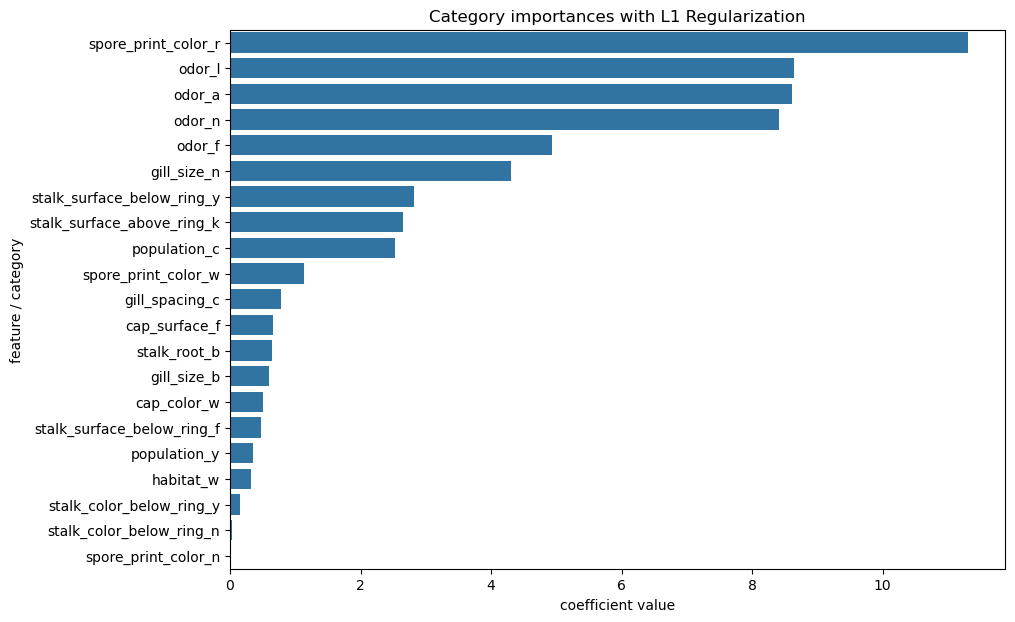

In [33]:
logr_cat_coef_df = pd.DataFrame({'features': logr_encoded_feature_names, 'coefficients': logr_coefficients})
logr_cat_coef_df['abs_coefficients'] = logr_cat_coef_df['coefficients'].abs()
logr_cat_coef_df = logr_cat_coef_df[logr_cat_coef_df['coefficients'] != 0]
logr_cat_coef_df = logr_cat_coef_df.sort_values(by = 'abs_coefficients', ascending = False)

plt.figure(figsize = (10, 7))
sns.barplot(x = 'abs_coefficients', y = 'features', data = logr_cat_coef_df)
plt.xlabel('coefficient value')
plt.ylabel('feature / category')
plt.title('Category importances with L1 Regularization')
plt.show()

Since the features have been one - hot encoded, the solver find separate coefficients for each category. These coefficients show how each specific category influences the probability of predicting the positive class. Of course, they are shrаnk by the regularization term and some are completely gone, because L1 regularization is applied. 

We can observe that the most significant category is "spore_print_color_r" which corresponds to green color os spores. The EDA above shows that there are 78 observations containing this category, and all of them are of poisonous mushrooms. For the same feature the algorithm found as less signifficant the "white"(w) and "numerous"(n) categories. Тhe absence of other categories that EDA defined as significant, within "spore_print_color" feature, like "black"(k) and "chocolate"(h) is noticeable. It is due to the used L1 regularization.

The next most significant categories belong to "odor" feature. As noted in EDA, this column seems to be the most important for the classification of the target variable label. Still some of it's categories which contain only observations with no mixed labels, are penalized by the Lasso to values of zero. Generally, from all 116 categories just 21 are left.

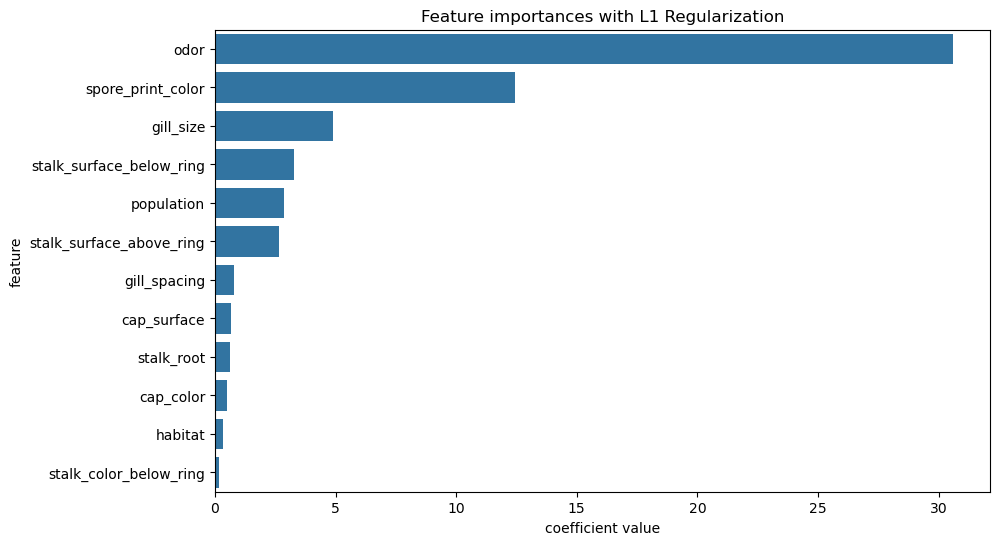

In [34]:
logr_cat_coef_df['original_features'] = logr_cat_coef_df['features'].apply(lambda name: name.rsplit('_', 1)[0])

feature_importance_df = logr_cat_coef_df.groupby('original_features')['abs_coefficients'].sum().reset_index()
feature_importance_df = feature_importance_df.sort_values(by = 'abs_coefficients', ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'abs_coefficients', y = 'original_features', data = feature_importance_df)
plt.xlabel('coefficient value')
plt.ylabel('feature')
plt.title('Feature importances with L1 Regularization')
plt.show()

To interpret the importance of original features, the one-hot encoded coefficients are grouped. Like in the EDA insights, the most telling feature determined by the solver is "odor", followed by "spore_print_color". It is noticeable the absence of another very telling(based on data analysis) feature - "gill_color". With that exception, all signifficant features, found in EDA have coefficients greater than zero. Their magnitude(absolute value) indicates the strength of the influence of the corresponding feature. From 21 columns, 12 are left after the applied Lasso regularization.

#### Evaluation with test data

The trained model is evaluated on a test set to assess how well the it generalizes to new, unseen data.
This should provide an unbiased estimate of the model performance, detect overfitting, and a real world scenarios.
Two types of predictions of target variable class are made and observed - of labels and of probabilities.

In [35]:
logr_predicted = logr_pipe.predict(mushroom_attr_test)

In [36]:
logr_prob = logr_pipe.predict_proba(mushroom_attr_test)

In [63]:
logr_conf_matrix = confusion_matrix(mushroom_target_test, logr_predicted)

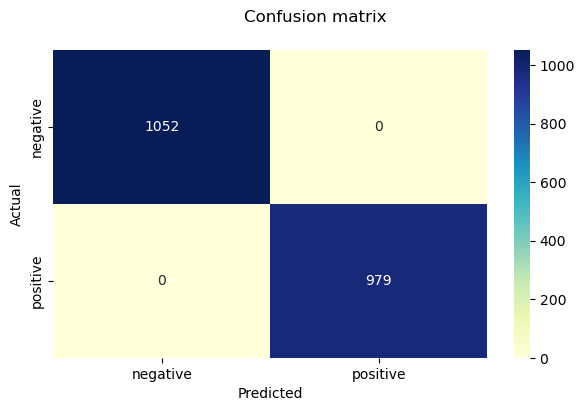

In [64]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))

sns.heatmap(logr_conf_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')

axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')
axes.xaxis.set_ticklabels(['negative', 'positive'])
axes.yaxis.set_ticklabels(['negative', 'positive'])
fig.suptitle('Confusion matrix')

plt.show()

The confusion matrix shows that all predictions of test data labels made by the model are correct. This is an indication that the model does not overfitting and generalize well, at least on the test data. Since the evaluation metrics are derivatives of the confusion matrix, it can be concluded that they will have a perfect score. They are calculated and compared with the mean evaluation metric scores achieved during the training of the model.

In [77]:
compared_metrics = {
    'metric': ['recall', 'accuracy', 'roc_auc'],
    'cross_validation': [logr_trials_df['mean_recall'].mean(), logr_trials_df['mean_accuracy'].mean(), logr_trials_df['mean_roc_auc'].mean()],
    'test_set': [recall_score(mushroom_target_test, logr_predicted, pos_label = 'p'), accuracy_score(mushroom_target_test, logr_predicted), roc_auc_score(mushroom_target_test, logr_prob[:, 1])]
}

comapared_metrics_df = pd.DataFrame(compared_metrics)
comapared_metrics_df = comapared_metrics_df.melt(id_vars = 'metric', var_name = 'evaluation', value_name = 'score')

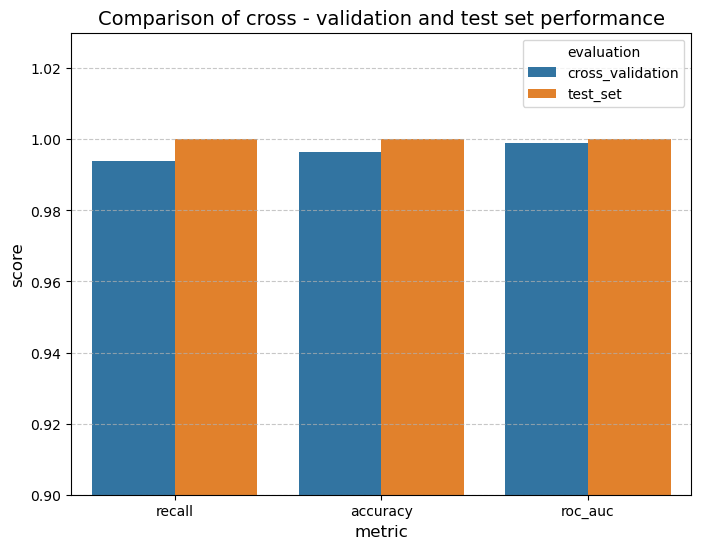

In [76]:
plt.figure(figsize = (8, 6))
sns.barplot(data = comapared_metrics_df, x = 'metric', y = 'score', hue = 'evaluation')

plt.title('Comparison of cross - validation and test set performance', fontsize = 14)
plt.ylim(0.9, 1.03)
plt.ylabel('score', fontsize = 12)
plt.xlabel('metric', fontsize = 12)
plt.grid(axis= 'y', linestyle = '--', alpha = 0.7)

plt.show()

As espexted from the observation of the confusion matrix, all three evaluation metrics have a socre of 1.0. They are equal compared to the cross - validation metrics of the selected model, which also are perfect. The plot above shows that the differences with the mean evaluation scores, achieved during the training of the model, are very small, close to the standard deviations observed in the tuning trials.

These results confirm that the high scores achieved during cross - validation are not a result of overfitting. The selected model performs equally on train and unseen data. It can be concluded that the test data is an good representation of the train data.

In [40]:
mushroom_target_test.value_counts()

label
e    1052
p     979
Name: count, dtype: int64

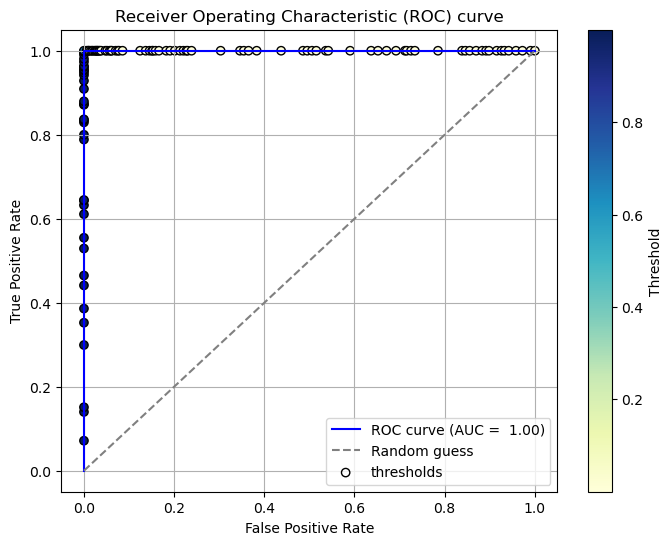

In [73]:
logr_false_pos_rate, logr_true_pos_rate, thresholds = roc_curve(mushroom_target_test, logr_prob[:, 1], pos_label = 'p')

logr_test_roc_auc = roc_auc_score(mushroom_target_test, logr_prob[:, 1])

plt.figure(figsize = (8, 6))
plt.plot(logr_false_pos_rate, logr_true_pos_rate, label = f'ROC curve (AUC = {logr_test_roc_auc: .2f})', color = 'blue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random guess')
plt.scatter(logr_false_pos_rate, logr_true_pos_rate, c = thresholds, cmap = 'YlGnBu', label = 'thresholds', edgecolors = 'k')
plt.colorbar(label = 'Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Receiver Operating Characteristic curve represents the performance of the model at different classification thresholds. It plots the possible True Positive rates against the False Positive ones. ROC curve AUC score summarizes the mode's performance across all possible classification thresholds and is equal to the area under the ROC curve. Since the model makes perfec predictions on the test data, the AUC is 1 and the performance remains constantly perfect on all thresholds.

In order to evaluate the model's performance in different important and real world cases, the test data is filtered and splitted below on several subsets.

Below the model is tested on subset of the test data, where the predictted probabilities of the positive class are very high. This is a subset with only poisonous observations. The perfect results of this evaluation confirms that the model is highly confident in its classifications.

In [97]:
high_confidence_attr_test = mushroom_attr_test[(logr_prob[:, 1] > 0.95)]
high_confidence_target_test = mushroom_target_test[(logr_prob[:, 1] > 0.95)]
logr_high_conf_pred = logr_pipe.predict(high_confidence_attr_test)

In [98]:
recall_score(high_confidence_target_test, logr_high_conf_pred, pos_label = 'p')

1.0

The test data is filtered to a subset where the predicted probabilities are relatively close to the threshold of 0.5. It is noticeable that there are only two observations where the model shows even a small uncertainty.

In [44]:
low_confidence_reccords = mushroom_attr_test[(logr_prob[:, 1] > 0.3) & (logr_prob[:, 1] < 0.7)]
low_confidence_reccords

,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
4364,b,y,w,t,n,f,w,n,w,e,b,s,s,w,w,w,o,p,w,c,l
5107,f,g,w,t,n,f,w,n,w,e,b,s,s,w,w,w,o,p,w,c,l


In the real world, if the model is used in cultivation industry to ensure the abscence of accidentally precence of toxic mushrooms, normally the samples will contain zero or very small percentage positive probes. To check the performance in such situations, the test data is splitted on a subset of only edible observations and another, containing only one percent positive samples. 

In [45]:
imbalanced_mushroom_test = pd.concat([mushroom_attr_test, mushroom_target_test], axis = 1).sort_values(by = 'label').head(1070)

In [46]:
imbalanced_mushroom_test = imbalanced_mushroom_test.sample(frac = 1, random_state = RANDOM_SEED)

In [47]:
imbalanced_mushroom_test['label'].value_counts(normalize = True) * 100

label
e    98.317757
p     1.682243
Name: proportion, dtype: float64

In [48]:
imbalanced_mushroom_attr = imbalanced_mushroom_test.drop(columns = ['label'])

In [49]:
imbalanced_mushroom_target = imbalanced_mushroom_test['label']

In [50]:
logr_imbalanced_prediction = logr_pipe.predict(imbalanced_mushroom_attr)

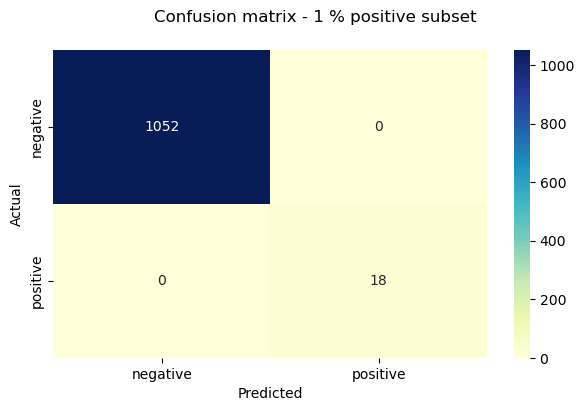

In [95]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))

sns.heatmap(confusion_matrix(imbalanced_mushroom_target, logr_imbalanced_prediction), annot = True, fmt = 'd', cmap = 'YlGnBu')

axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')
axes.xaxis.set_ticklabels(['negative', 'positive'])
axes.yaxis.set_ticklabels(['negative', 'positive'])
fig.suptitle('Confusion matrix - 1 % positive subset')

plt.show()

In [52]:
zero_positive_attr = mushroom_attr_test[mushroom_target_test == 'e']
zero_positive_target = mushroom_target_test[mushroom_target_test == 'e']

In [53]:
len(zero_positive_attr) == len(zero_positive_target)

True

In [54]:
logr_zero_positive_prediction = logr_pipe.predict(zero_positive_attr)

In [94]:
accuracy_score(zero_positive_target, logr_zero_positive_prediction)

1.0

The model performs without mistakes on the subset containing only observations of edible class as well on the subset with only several positive class reccords. This way is tested how well it generalize on possible real world scenarios.